<b><font size=3> Programming Exercise 8 | Anomaly Detection and Recommender Systems </b></font>

In this exercise, we will implement the anomaly detection algorithm and apply it to detect failing servers on a network.

<b> 1 | Anomaly Detection </b>

In [87]:
import os 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
from scipy.io import loadmat
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

In [88]:
os.chdir('/Users/christinakouride/Documents/Python/Learning/Andrew Ng - ML course/ex8')

data = loadmat('ex8data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [89]:
X = data['X']
Xval = data['Xval']

Yval = data['yval']

print("X shape: ", X.shape)
print("Xval shape: ", Xval.shape)
print("Yval shape: ", Yval.shape)

X shape:  (307, 2)
Xval shape:  (307, 2)
Yval shape:  (307, 1)


In [90]:
def plotdata(Xs):
    plt.figure(figsize=(10, 8))
    plt.scatter(Xs[:,0],Xs[:,1],marker = 'x', color = 'b', s=30, linewidth =0.5)

    plt.xlabel("Latency (ms)")
    plt.ylabel("Throughput (mb/s)")

    plt.xlim(0,30)
    plt.ylim(0,30)

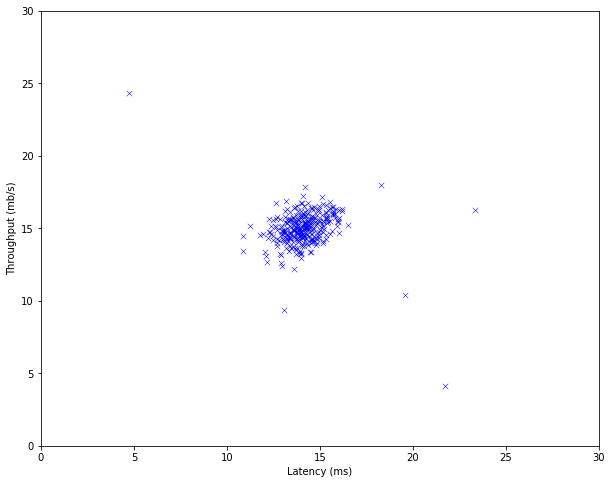

In [91]:
plotdata(X)

<b>1.1 | Gaussian distribution </b>

In [92]:
def estimateGaussian(Xs):
    mu = sp.mean(Xs, axis = 0)
    sigma2 = sp.var(Xs, axis = 0, ddof = 1)
    return mu, sigma2

In [93]:
def multivariateGaussian(Xs, mu, sigma2):
    sigma2 = sp.diag(sigma2) #covariance matrix of the distribution    
    p = multivariate_normal(mean=mu, cov=sigma2)
    return p.pdf(Xs)

In [94]:
mu, sigma2 = estimateGaussian(X)

In [95]:
p = multivariateGaussian(X, mu, sigma2)
p.shape

(307,)

In [96]:
def plotContours(mu, sigma2, newFig=False):
    delta = .1
    myx = np.arange(0,30,delta)
    myy = np.arange(0,30,delta)
                 
    meshx, meshy = np.meshgrid(myx, myy)
    coord_list = [entry.ravel() for entry in (meshx, meshy)]
    points = np.vstack(coord_list).T
    
    myz = multivariateGaussian(points, mu, sigma2)
    myz = myz.reshape((myx.shape[0],myx.shape[0]))

    if newFig: plt.figure(figsize=(6,4))
    
    cont_levels = [10**exp for exp in range(-20,0,3)]
    mycont = plt.contour(meshx, meshy, myz, levels=cont_levels, c='b')

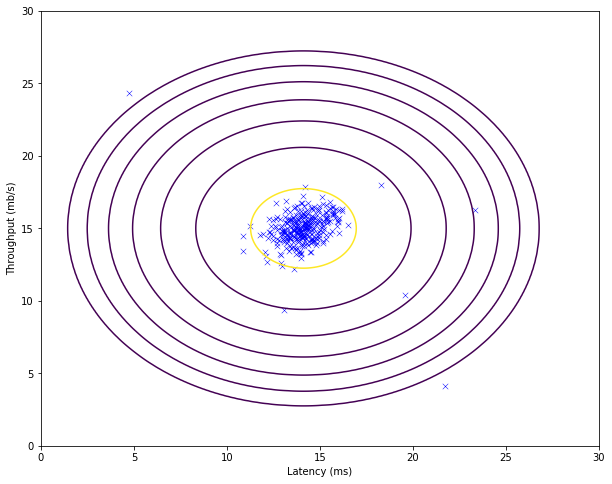

In [97]:
plotdata(X)
plotContours(mu, sigma2)

<b> 1.3 | Selecting the threshold, epsilon </b>

In [98]:
#Repeat for validation set to determine optimal probability threshold using true labels
pval = multivariateGaussian(Xval, mu, sigma2)
pval.shape

(307,)

In [99]:
def selectThreshold(Yval, pval):
    optimum_epsilon, optimum_F1 = 0, 0
    step = (pval.max() - pval.min()) / 1000

    for epsilon in sp.arange(pval.min(), pval.max(), step)[1:]:
        cv_prediction = pval < epsilon

        tp = sp.sum((cv_prediction == 1) & (Yval.ravel() == 1))
        fp = sp.sum((cv_prediction == 1) & (Yval.ravel() == 0))
        fn = sp.sum((cv_prediction == 0) & (Yval.ravel() == 1))
        
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        F1 = (2*prec*rec) / (prec + rec)
        
        if F1 > optimum_F1:
            optimum_epsilon = epsilon
            optimum_F1 = F1
        
    return optimum_epsilon, optimum_F1

In [100]:
optimum_epsilon, optimum_F1 = selectThreshold(Yval.ravel(), pval)

print("Optimal epsilon: ",optimum_epsilon)
print("F1 score at optimal epsilon: ", optimum_F1)

Optimal epsilon:  8.961567687193517e-05
F1 score at optimal epsilon:  0.8750000000000001


In [101]:
outliers = X[p < optimum_epsilon]
outliers.shape

(6, 2)

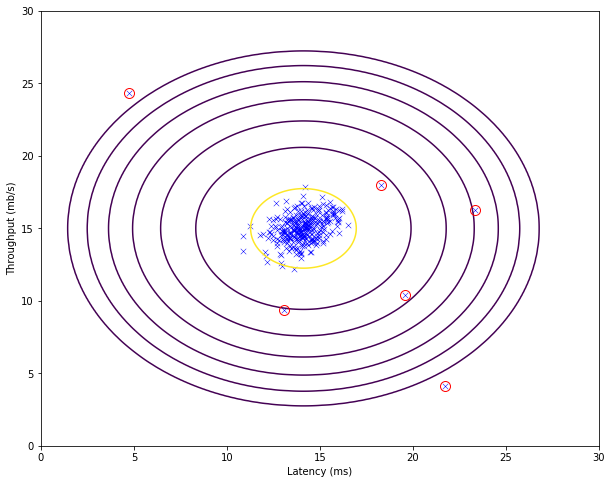

In [102]:
plotdata(X)
plotContours(mu, sigma2)
plt.plot(outliers[:,0],outliers[:,1], 'ro', ms = 10, mfc='none', mec='r')

<b> 1.4 | High dimensional dataset </b>

In [103]:
data2 = loadmat('ex8data2.mat')
data2.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [104]:
X2 = data2['X']
X2val = data2['Xval']

Y2val = data2['yval']

print("X shape: ", X2.shape)
print("Xval shape: ", X2val.shape)
print("Yval shape: ", Y2val.shape)

X shape:  (1000, 11)
Xval shape:  (100, 11)
Yval shape:  (100, 1)


In [105]:
mu2, sigma22 = estimateGaussian(X2)
p2 = multivariateGaussian(X2, mu2, sigma22)
p2val = multivariateGaussian(X2val, mu2,sigma22)

In [106]:
optimum_epsilon2, optimum_F12 = selectThreshold(Y2val.ravel(), p2val)

In [107]:
print('Best epsilon found using cross-validation: ', optimum_epsilon2)
print('Best F1 on Cross Validation Set: ', optimum_F12)
print('# Outliers found: ', sum(p2 < optimum_epsilon2))

Best epsilon found using cross-validation:  1.371660675040733e-18
Best F1 on Cross Validation Set:  0.6153846153846154
# Outliers found:  117


<b> 2 | Recommender systems </b>

<b> 2.1 | Movie ratings dataset </b>

In [108]:
data_m = loadmat('ex8_movies.mat')
data_m.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [109]:
Y = data_m['Y']
R = data_m['R']
print("num_movies(i) x num_users(j): ",Y.shape)
print("unrated movies: ", np.sum(R==0), ",rated movies: ", np.sum(R==1))

num_movies(i) x num_users(j):  (1682, 943)
unrated movies:  1486126 ,rated movies:  100000


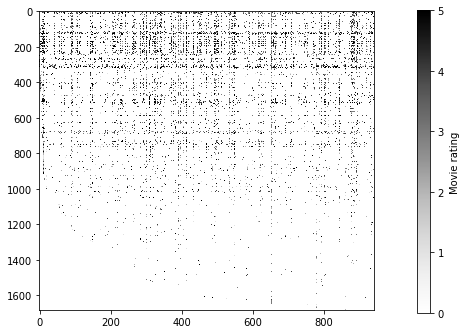

In [110]:
fig = plt.figure(figsize=(6,6))
imshow_out = plt.imshow(Y, cmap=plt.get_cmap('Greys'), vmin=0, vmax=5, interpolation = 'nearest', aspect=0.5)

cbaxes = fig.add_axes([1, 0.15, 0.03, 0.7]) 
markersize = plt.rcParams['lines.markersize'] # The adjustments to 'lines.markersize' in this code block prevent points of size "markersize" from appearing in the corners of the colorbar.
cbaxes.text(2.5, 0.5,'Movie rating', verticalalignment='center', horizontalalignment='left', rotation=90)

fig.colorbar(imshow_out, cax = cbaxes)

<b> 2.2 | Collaborative filtering learning algorithm </b>

In [111]:
movies = loadmat('ex8_movieParams.mat')
movies.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

<b> 2.2.1 & 2.2.2 | Collaborative filtering cost function & gradient </b>

In [112]:
X = movies['X']
Theta = movies['Theta']
num_users = movies['num_users']
num_movies = movies['num_movies']
num_features = movies['num_features']

In [113]:
def cofiCostFunc(params, Y, R, num_features, lmbda):
    num_movies = Y.shape[0]
    num_users = Y.shape[1]

    X = params[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = params[num_movies * num_features:].reshape(num_users, num_features)

    J = (1/2)*np.sum(np.square(np.multiply(X.dot(Theta.T) - Y, R))) + (lmbda / 2) * np.sum(np.square(X)) + (lmbda / 2 ) * np.sum(np.square(Theta))

    X_grad = np.dot(np.multiply(X.dot(Theta.T) - Y,R), Theta) + lmbda * X
    Theta_grad = np.dot(np.multiply(X.dot(Theta.T) - Y,R).T, X) + lmbda * Theta
    
    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))
    return J, grad

In [114]:
#Reduce dataset so that this runs faster
num_users, num_movies, num_features = 4, 5, 3

X_red = X[:num_movies, :num_features]
Theta_red = Theta[:num_users, :num_features]
Y_red = Y[:num_movies, :num_users]
R_red = R[:num_movies, :num_users]

params = np.hstack((X_red.ravel(), Theta_red.ravel()))

In [118]:
J, grad = cofiCostFunc(params, Y_red, R_red, num_features, 0)
print("For lambda = 0","\n")
print("Cost equals to ",J,"\n")
print("Grad equals to ","\n",grad)

For lambda = 0 

Cost equals to  22.224603725685675 

Grad equals to  
 [ -2.52899165   7.57570308  -1.89979026  -0.56819597   3.35265031
  -0.52339845  -0.83240713   4.91163297  -0.76677878  -0.38358278
   2.26333698  -0.35334048  -0.80378006   4.74271842  -0.74040871
 -10.5680202    4.62776019  -7.16004443  -3.05099006   1.16441367
  -3.47410789   0.           0.           0.           0.
   0.           0.        ]


In [122]:
J, grad = cofiCostFunc(params, Y_red, R_red, num_features, 1)
print("For lambda = 1","\n")
print("Cost equals to ",J,"\n")
print("Grad equals to ","\n",grad)

For lambda = 1 

Cost equals to  28.304238738078038 

Grad equals to  
 [-1.48030614e+00  7.17547112e+00 -7.05670813e-01  2.12655265e-01
  2.96702440e+00 -2.20066906e-03 -1.90898273e-01  4.36377912e+00
 -8.50575155e-01  7.00350400e-02  1.46311855e+00  3.27140802e-01
  1.33757827e-01  4.84880832e+00 -3.78455758e-01 -1.02825766e+01
  2.94349510e+00 -6.89710566e+00 -2.54597685e+00  7.09765208e-01
 -3.15664544e+00 -4.31916561e-01 -4.78804489e-01  8.46711106e-01
  7.28598385e-01 -2.71893905e-01  3.26843604e-01]


In [123]:
J, grad = cofiCostFunc(params, Y_red, R_red, num_features, 1.5)
print("For lambda = 1.5","\n")
print("Cost equals to ",J,"\n")
print("Grad equals to ","\n",grad)

For lambda = 1.5 

Cost equals to  31.344056244274217 

Grad equals to  
 [ -0.95596339   6.97535514  -0.10861109   0.60308088   2.77421145
   0.25839822   0.12985616   4.0898522   -0.89247334   0.29684395
   1.06300933   0.66738144   0.60252677   4.90185327  -0.19747928
 -10.13985478   2.10136256  -6.76563628  -2.29347024   0.48244098
  -2.99791422  -0.64787484  -0.71820673   1.27006666   1.09289758
  -0.40784086   0.49026541]


<b> 2.3 | Learning movie recommendations </b>

In [126]:
movie_list = 'movie_ids.txt'
movie_idx = []
with open(movie_list, encoding = "ISO-8859-1", mode = "r") as f:
    for line in f:
        movie_idx.append(' '.join(line.strip('\n').split(' ')[1:]))

In [127]:
my_ratings = np.zeros((1682,1))

my_ratings[0] = 4;
my_ratings[6] = 3;
my_ratings[11]= 5;
my_ratings[53] = 4;
my_ratings[63] = 5;
my_ratings[65]= 3;
my_ratings[68] = 5;
my_ratings[97] = 2;
my_ratings[182] = 4;
my_ratings[225]= 5;
my_ratings[354]= 5;

In [128]:
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print("Rated {0} with {1} stars".format(movie_idx[i],int(my_ratings[i])))

Rated Toy Story (1995) with 4 stars
Rated Twelve Monkeys (1995) with 3 stars
Rated Usual Suspects, The (1995) with 5 stars
Rated Outbreak (1995) with 4 stars
Rated Shawshank Redemption, The (1994) with 5 stars
Rated While You Were Sleeping (1995) with 3 stars
Rated Forrest Gump (1994) with 5 stars
Rated Silence of the Lambs, The (1991) with 2 stars
Rated Alien (1979) with 4 stars
Rated Die Hard 2 (1990) with 5 stars
Rated Sphere (1998) with 5 stars


<b> 2.3.1 | Recommendations </b>

In [1054]:
print(Y.shape, R.shape)

(1682, 943) (1682, 943)


In [129]:
# Add custom ratings to our dataset
Y_movies = sp.hstack((my_ratings.reshape(-1, 1), Y))
R_movies = sp.hstack(((my_ratings != 0).reshape(-1, 1), R))

In [130]:
print(Y_movies.shape, R_movies.shape)

(1682, 944) (1682, 944)


In [131]:
#Useful values
num_movies = Y_movies.shape[0]
num_users = Y_movies.shape[1]
num_features = 10 
lmbda = 10.

#Initialise parameters
X_movies = np.random.rand(num_movies, num_features)
Theta_movies = np.random.rand(num_users, num_features)

params_movies = sp.hstack((X_movies.ravel(), Theta_movies.ravel()))

In [132]:
fmin = minimize(fun=cofiCostFunc, x0=params_movies, args=(Y_movies, R_movies, num_features, lmbda), method='TNC', jac=True, options={'maxiter': 1000})
fmin

     fun: 71897.3647183617
     jac: array([-2.23031821e-05,  4.60553104e-06, -2.23162076e-05, ...,
       -5.67304888e-06, -1.17195474e-05,  3.34641164e-06])
 message: 'Max. number of function evaluations reached'
    nfev: 1000
     nit: 37
  status: 3
 success: False
       x: array([ 0.72810357,  0.33876114, -0.01589013, ...,  0.91768246,
        1.10363373,  0.99972265])

In [133]:
params_movies = fmin.x

X_movies = params_movies[:num_movies * num_features].reshape(num_movies, num_features)
Theta_movies = params_movies[num_movies * num_features:].reshape(num_users, num_features)

In [134]:
# Grab the last user's predictions (since our predictions were put at the end of the Y matrix, not the front)
my_predictions = np.dot(X_movies, Theta_movies.T)[:,0]

my_predictions = my_predictions

In [47]:
# Sort my predictions from highest to lowest
pred_idxs_sorted = np.argsort(my_predictions)[::-1]

In [53]:
print("Top recommendations for you: ")
for i in range(10):
    j = pred_idxs_sorted[i]
    print("Predicting rating {0} for movie {1}".format(round(my_predictions[j],1),movie_idx[j]))

print("\n")

print("Original ratings provided:")
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print("Rated {0} with {1} stars".format(movie_idx[i],int(my_ratings[i])))

Top recommendations for you: 
Predicting rating 4.3 for movie Titanic (1997)
Predicting rating 4.1 for movie Star Wars (1977)
Predicting rating 4.0 for movie Raiders of the Lost Ark (1981)
Predicting rating 3.9 for movie Good Will Hunting (1997)
Predicting rating 3.9 for movie Shawshank Redemption, The (1994)
Predicting rating 3.9 for movie Return of the Jedi (1983)
Predicting rating 3.9 for movie Braveheart (1995)
Predicting rating 3.9 for movie Empire Strikes Back, The (1980)
Predicting rating 3.8 for movie Terminator 2: Judgment Day (1991)
Predicting rating 3.8 for movie As Good As It Gets (1997)


Original ratings provided:
Rated Toy Story (1995) with 4 stars
Rated Twelve Monkeys (1995) with 3 stars
Rated Usual Suspects, The (1995) with 5 stars
Rated Outbreak (1995) with 4 stars
Rated Shawshank Redemption, The (1994) with 5 stars
Rated While You Were Sleeping (1995) with 3 stars
Rated Forrest Gump (1994) with 5 stars
Rated Silence of the Lambs, The (1991) with 2 stars
Rated Alien (